# Estimation Hurst

In [38]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np
import pandas as pd
from fbm import FBM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Préparation des données

In [39]:
M_train= 10000 # nombre de série temporelle train
T = 100
H_min = 0.1
H_max = 0.9

H_train = np.linspace(H_min, H_max, 10)
# génération des séries temporelles train
def one_time_serie(hurst, length=1, n=T):
    return FBM(n=n, hurst=hurst,length=length).fbm()[1:] # on ne prend pas la première valeur qui vaut 0


In [40]:
X_train =[]
y_train = []
for _ in range(M_train):
    for H in H_train:
        X_train.append(one_time_serie(hurst=H))
        y_train.append(H)
X_train = np.vstack(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

/Users/user/anaconda3/lib/python3.11/site-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


(100000, 100)
(100000,)


In [41]:
# génération des séries temporelles test
H_test = np.linspace(0.01, 0.99,100).tolist()

M_test= 1000 # nombre de série temporelle test
X_test =[]
y_test = []
for _ in range(M_test):
    for H in H_test:
        X_test.append(one_time_serie(hurst=H))
        y_test.append(H)
y_test = np.array(y_test)
X_test = np.vstack(X_test)
print(X_test.shape)
print(y_test.shape)

(100000, 100)
(100000,)


In [42]:
def save_parquet(X_array, y_array, file_path):
  df = pd.DataFrame(X_array)
  df.columns = [str(x) for x in df.columns]
  df["y"] = y_array
  df.to_parquet(file_path, engine="pyarrow")

def load_parquet(file_path):
  df = pd.read_parquet(file_path, engine="pyarrow")
  return df["y"].to_numpy(), df.iloc[:, :-1].to_numpy()

In [43]:
# save_parquet(X_train, y_train, "X_train.parquet")
# save_parquet(X_test, y_test, "X_test.parquet")

In [44]:
# y_train, X_train = load_parquet("X_train.parquet")
# y_test, X_test = load_parquet("X_test.parquet")

In [45]:
scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train.T).T

scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X_test.T).T

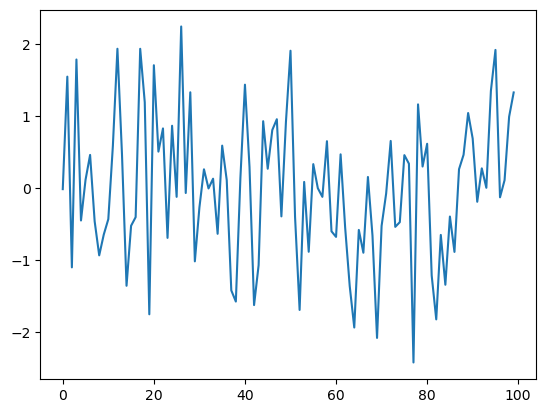

In [46]:
plt.plot(X_test[500,:])

### 1. Réseaux Denses

In [47]:
num_epochs = 500

In [48]:
model = Sequential ()

model.add(Dense(T, input_dim=T, activation="sigmoid"))

model.add(Dense(T/5, activation="relu"))

model.add(Dense(T/10, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="mse", optimizer="adam")

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 20)                2020      
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 12341 (48.21 KB)
Trainable params: 12341 (48.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
2813/2813 [==============================] - 1s 376us/step - loss: 0.0311 - val_loss: 0.0249
Epoch 2/500
2813/2813 [==============================] - 1s 359us/step - loss: 0.0226 - val_loss: 0.0220
Epoch 3/500
2813/2813 [==============================] - 1s 360us/step - loss: 0.0207 - val_loss: 0.0204
Epoch 4/500
2813/2813 [==============================] - 1s 366us/step - loss: 0.0192 - val_loss: 0.0190
Epoch 5/500
2813/2813 [==============================] - 1s 334us/step - loss: 0.0177 - val_loss: 0.0183
Epoch 6/500
2813/2813 [==============================] - 1s 392us/step - loss: 0.0168 - val_loss: 0.0170
Epoch 7/500
2813/2813 [==============================] - 1s 361us/step - loss: 0.0161 - val_loss: 0.0163
Epoch 8/500
2813/2813 [==============================] - 1s 358us/step - loss: 0.0156 - val_loss: 0.0157
Epoch 9/500
2813/2813 [==============================] - 1s 360us/step - loss: 0.0150 - val_loss: 0.0155
Epoch 10/500
2813/2813 [==============================]

2813/2813 [==============================] - 2s 624us/step - loss: 0.0062 - val_loss: 0.0077
Epoch 79/500
2813/2813 [==============================] - 2s 622us/step - loss: 0.0062 - val_loss: 0.0077
Epoch 80/500
2813/2813 [==============================] - 2s 663us/step - loss: 0.0061 - val_loss: 0.0076
Epoch 81/500
2813/2813 [==============================] - 2s 693us/step - loss: 0.0061 - val_loss: 0.0076
Epoch 82/500
2813/2813 [==============================] - 2s 652us/step - loss: 0.0061 - val_loss: 0.0076


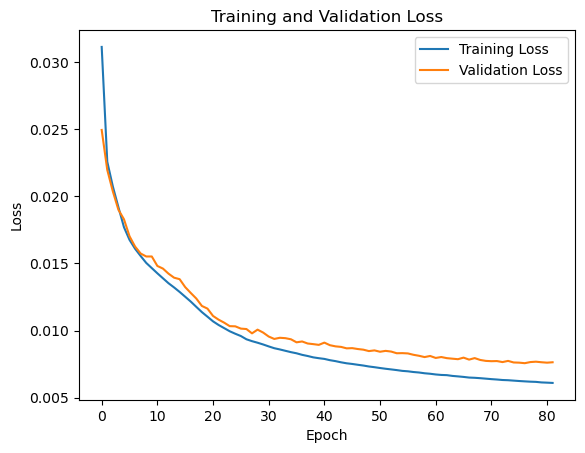

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
predictions = model.predict(X_test).flatten()

3125/3125 [==============================] - 1s 409us/step


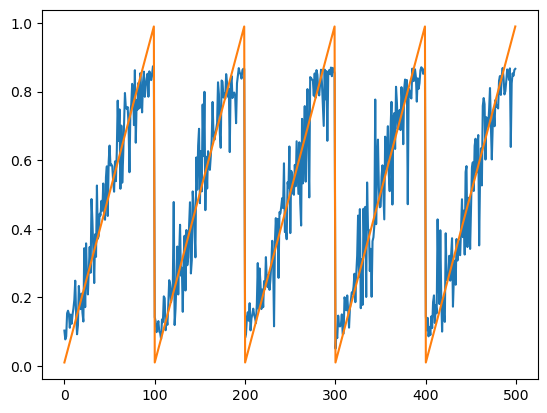

In [53]:
plt.plot(predictions[:500])
plt.plot(y_test[:500])

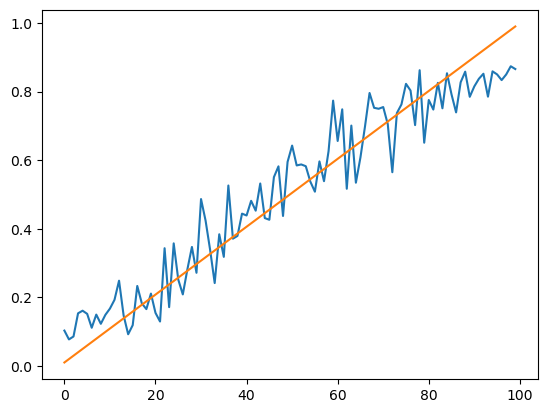

In [54]:
plt.plot(predictions.reshape(1000, 100)[0])
plt.plot(y_test[:100])

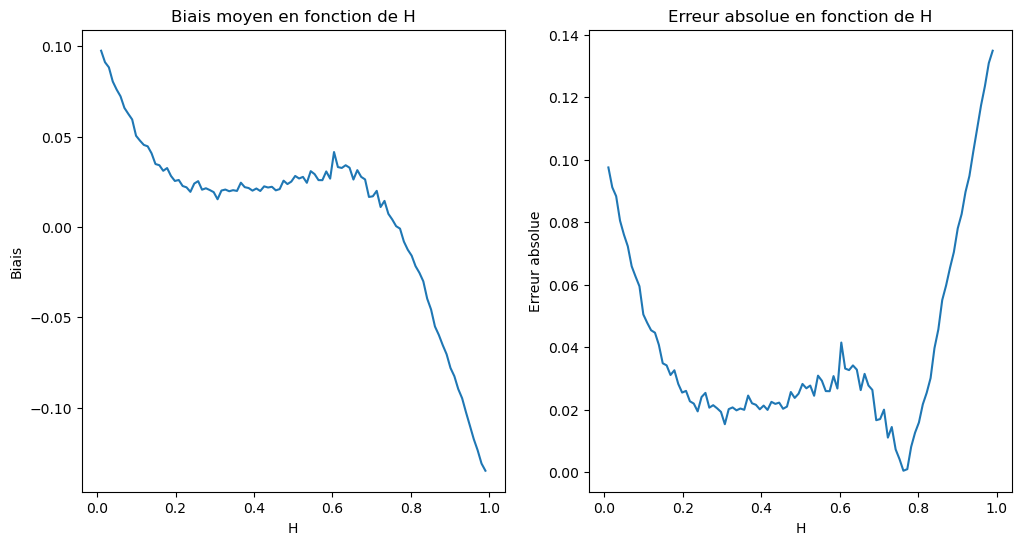

In [55]:
biais = np.mean(predictions.reshape(1000, 100), axis=0) - y_test[:100]

abs_error = np.abs(biais)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y_test[:100], biais)
plt.xlabel('H')
plt.ylabel('Biais')
plt.title('Biais moyen en fonction de H')

plt.subplot(122)
plt.plot(y_test[:100], abs_error * np.ones(len(y_test[:100])))
plt.xlabel('H')
plt.ylabel('Erreur absolue')
plt.title('Erreur absolue en fonction de H')

plt.show()

Nous remarquons que la performance de notre réseau est très bonne lorsque H est proche de 0.5. Lorsque celle-ci s'éloigne, nous avons une erreur absolue plus importante. Afin de rendre cet esimateur plus robuste aux outliers, il y a plusieurs possibilités. La première est d'utiliser une fonction de coût personnalisé qui pénaliserais lors de la présence d'outliers. Nous pourrions également essayé d'implémenter d'autres architectures pouvant être plus robustes. Enfin, nous pourrions essayer de construire un deuxième modèle en série qui rectifierait le biais de l'estimation (dans la même idée que le boosting).

# 2. Réseaux convolutifs unidimensionnels

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LeakyReLU, Flatten

model = Sequential([
    Conv1D(32, kernel_size=3, padding='same', input_shape=(100, 1)),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(64, kernel_size=3, padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(128, kernel_size=3, padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),

    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 100, 32)           128       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100, 32)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 32)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50, 64)            0         
                                                      

In [57]:
total_params = model.count_params()
print("Total parameters:", total_params)

Total parameters: 227905


In [58]:
X_train_expanded = np.expand_dims(X_train, axis=2)

history = model.fit(X_train_expanded, y_train, epochs=num_epochs, batch_size=64, validation_split=0.2, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 2/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 3/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 4/500
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 5/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 6/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 9/500
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 10/500
1250/1250 [==============================]

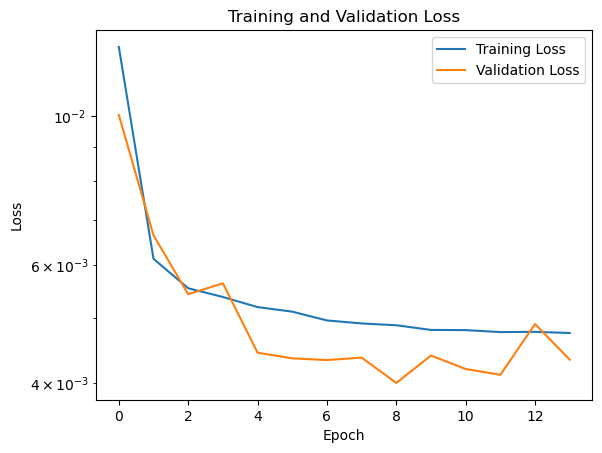

In [59]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
predictions_cnn = model.predict(X_test).flatten()

3125/3125 [==============================] - 6s 2ms/step


In [61]:
biais_cnn = np.mean(predictions_cnn.reshape(1000, 100), axis=0) - y_test[:100]

abs_error_cnn = np.abs(biais_cnn)

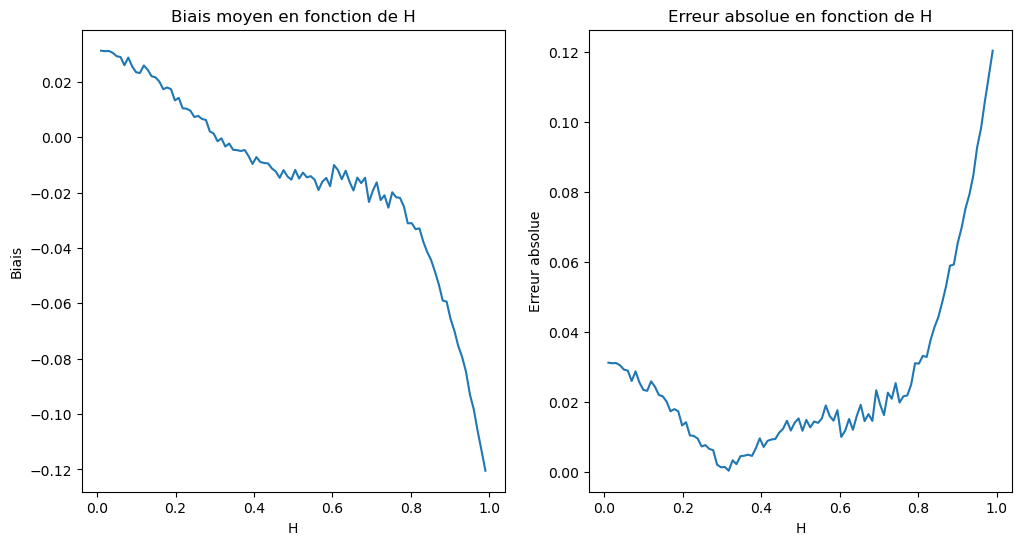

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y_test[:100], biais_cnn)
plt.xlabel('H')
plt.ylabel('Biais')
plt.title('Biais moyen en fonction de H')

plt.subplot(122)
plt.plot(y_test[:100], abs_error_cnn * np.ones(len(y_test[:100])))
plt.xlabel('H')
plt.ylabel('Erreur absolue')
plt.title('Erreur absolue en fonction de H')

plt.show()

Les interpréations sont les mêmes que dans le cadre d'une architetcture dense. Cependant, en plus des idées mentionnées précédemment, nous pourrions dans le cadre du CNN améliorer la robustesse aux outliers en ajoutant des couches de pooling qui peuvent agir comme des filtres robustes en réduisant la sensibilité du modèle aux variations locales mineures. Nous pouvons également entraîner notre modèle avec un plus grand nombre de mini-batch.
Il est également très intéressant de notifier que l'estimation du coefficient de Hurst semble à travers ces modèles plus difficile pour les coefficients de Hurst proche de 1, bien plus que pour un Hurst proche de 0.

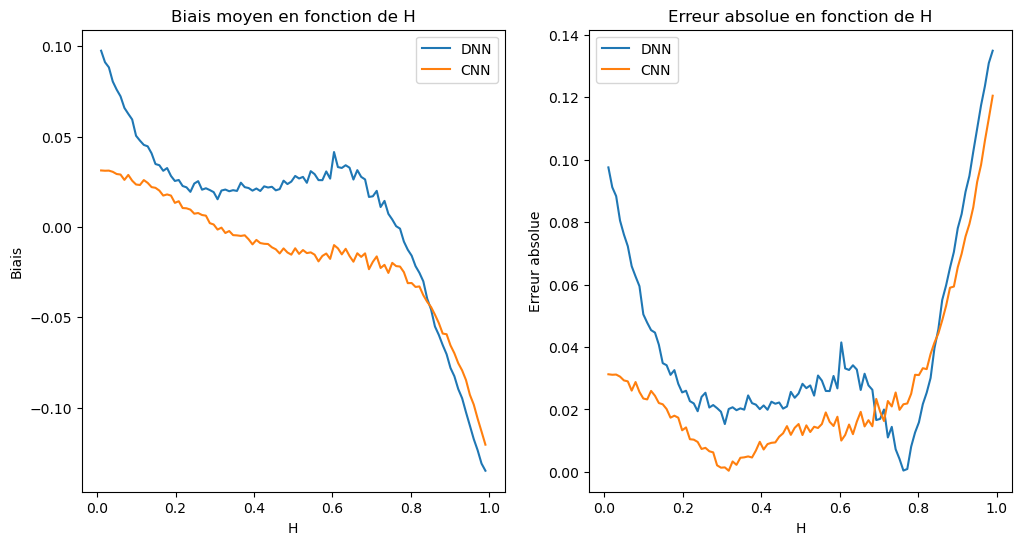

In [63]:
biais_cnn = np.mean(predictions_cnn.reshape(1000, 100), axis=0) - y_test[:100]

abs_error_cnn = np.abs(biais_cnn)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y_test[:100], biais, label="DNN")
plt.plot(y_test[:100], biais_cnn, label="CNN")
plt.xlabel('H')
plt.ylabel('Biais')
plt.title('Biais moyen en fonction de H')
plt.legend()

plt.subplot(122)
plt.plot(y_test[:100], abs_error * np.ones(len(y_test[:100])), label="DNN")
plt.plot(y_test[:100], abs_error_cnn * np.ones(len(y_test[:100])), label="CNN")
plt.xlabel('H')
plt.ylabel('Erreur absolue')
plt.title('Erreur absolue en fonction de H')
plt.legend()

plt.show()

La combinaison des prédictions d'un réseau neuronal profond (DNN) et d'un réseau neuronal convolutif (CNN) peut se faire de plusieurs manières, en fonction de ce qui est le plus logique pour votre application spécifique et la nature de vos données. Nous proposons ici quelques stratégies :

Calcul de la moyenne :

Moyenne simple : Prenez les prédictions des deux modèles et calculez la moyenne. Cette méthode est simple lorsque les prédictions sont des probabilités (par exemple, les sorties d'un softmax).
Moyenne pondérée : Attribuer des poids différents aux prédictions de chaque modèle en fonction de leur performance de validation, puis calculer la moyenne pondérée.
Vote :

Vote majoritaire : Pour les problèmes de classification, chaque modèle vote pour une classe de sortie, et la classe ayant obtenu la majorité des votes est choisie.
Vote souple : Au lieu d'un vote ferme, chaque modèle contribue à la décision finale par un vote pondéré en fonction de la confiance qu'il accorde à sa prédiction.

Empilage (méta-assemblage) :
Former un DNN et un CNN séparément, puis utiliser leurs prédictions comme caractéristiques pour un nouveau modèle (méta-apprenant), qui peut être un modèle simple comme la régression logistique, un autre réseau neuronal ou tout autre classificateur. Ce modèle est entraîné à faire la prédiction finale.

Renforcement (boosting) :
Utiliser les prédictions d'un modèle pour informer la formation d'un autre modèle. Par exemple, utiliser les erreurs du DNN pour mettre à jour et former le CNN, ou vice versa.

### Moyenne simple

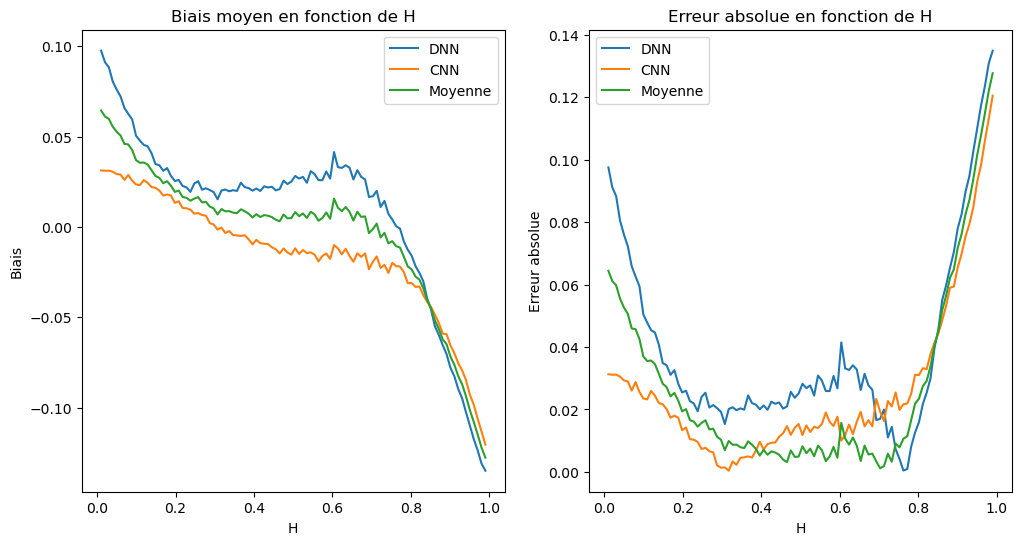

In [64]:
predictions_avg = (predictions + predictions_cnn)/2
biais_avg= np.mean(predictions_avg.reshape(1000, 100), axis=0) - y_test[:100]
abs_error_avg = np.abs(biais_avg)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y_test[:100], biais, label="DNN")
plt.plot(y_test[:100], biais_cnn, label="CNN")
plt.plot(y_test[:100], biais_avg, label="Moyenne")
plt.xlabel('H')
plt.ylabel('Biais')
plt.title('Biais moyen en fonction de H')
plt.legend()

plt.subplot(122)
plt.plot(y_test[:100], abs_error * np.ones(len(y_test[:100])), label="DNN")
plt.plot(y_test[:100], abs_error_cnn * np.ones(len(y_test[:100])), label="CNN")
plt.plot(y_test[:100], abs_error_avg * np.ones(len(y_test[:100])), label="Moyenne")
plt.xlabel('H')
plt.ylabel('Erreur absolue')
plt.title('Erreur absolue en fonction de H')
plt.legend()

plt.show()

### Boosting Entraînement d'un RNN sur les erreurs du CNN

In [65]:
model_errors = Sequential ()
model_errors.add(Dense(T, input_dim=T, activation="sigmoid"))
model_errors.add(Dense(T/100, activation="relu"))
model_errors.add(Dense(T/10, activation="relu"))
model_errors.add(Dense(T/100, activation="relu"))
model_errors.add(Dense(1, activation="sigmoid"))
model_errors.compile(loss="mse", optimizer="adam")

In [66]:
errors_train = y_train - model.predict(X_train).flatten()

3125/3125 [==============================] - 5s 2ms/step


In [67]:
history = model_errors.fit(X_train, errors_train, epochs=num_epochs, batch_size=32, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
2813/2813 [==============================] - 2s 726us/step - loss: 0.0814 - val_loss: 0.0206
Epoch 2/500
2813/2813 [==============================] - 2s 750us/step - loss: 0.0111 - val_loss: 0.0064
Epoch 3/500
2813/2813 [==============================] - 2s 714us/step - loss: 0.0050 - val_loss: 0.0043
Epoch 4/500
2813/2813 [==============================] - 2s 818us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 5/500
2813/2813 [==============================] - 2s 727us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 6/500
2813/2813 [==============================] - 2s 677us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/500
2813/2813 [==============================] - 2s 668us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/500
2813/2813 [==============================] - 2s 774us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 9/500
2813/2813 [==============================] - 2s 788us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/500
2813/2813 [==============================]

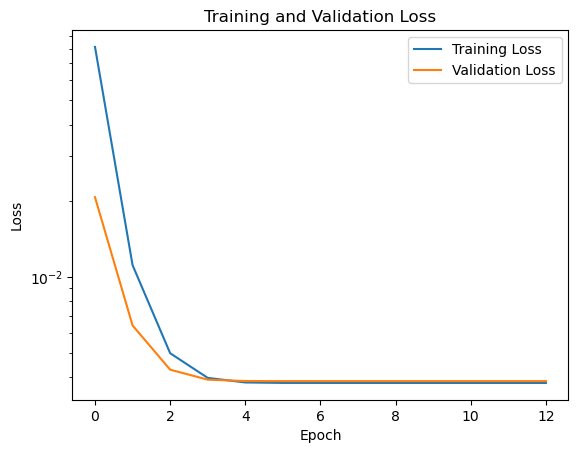

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
predicted_errors = model_errors.predict(X_test).flatten()

# Ajustement des prédictions du CNN
adjusted_predictions = predictions_cnn + predicted_errors

3125/3125 [==============================] - 2s 464us/step


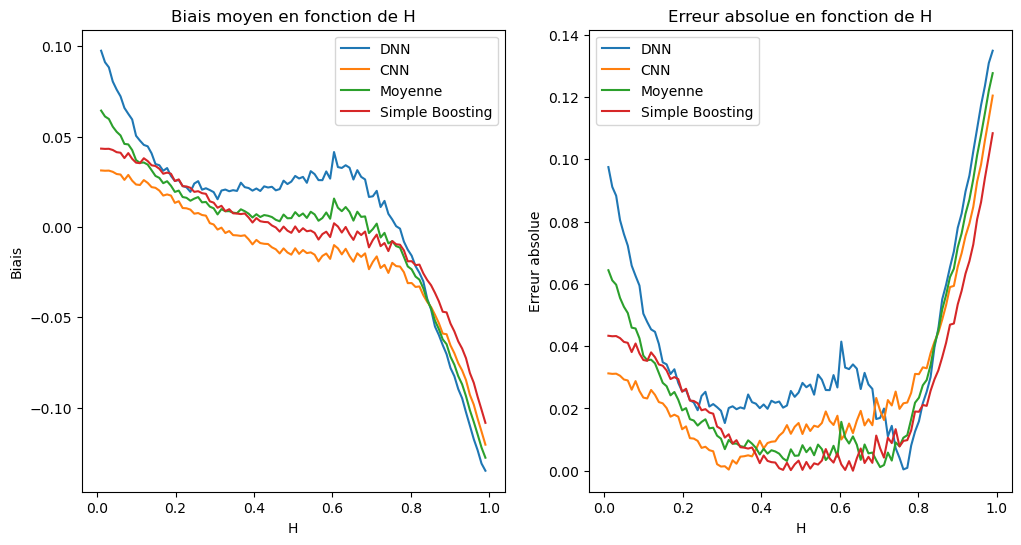

In [70]:
biais_adjusted= np.mean(adjusted_predictions.reshape(1000, 100), axis=0) - y_test[:100]
abs_error_adjusted = np.abs(biais_adjusted)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(y_test[:100], biais, label="DNN")
plt.plot(y_test[:100], biais_cnn, label="CNN")
plt.plot(y_test[:100], biais_avg, label="Moyenne")
plt.plot(y_test[:100], biais_adjusted, label="Simple Boosting")
plt.xlabel('H')
plt.ylabel('Biais')
plt.title('Biais moyen en fonction de H')
plt.legend()

plt.subplot(122)
plt.plot(y_test[:100], abs_error * np.ones(len(y_test[:100])), label="DNN")
plt.plot(y_test[:100], abs_error_cnn * np.ones(len(y_test[:100])), label="CNN")
plt.plot(y_test[:100], abs_error_avg * np.ones(len(y_test[:100])), label="Moyenne")
plt.plot(y_test[:100], abs_error_adjusted * np.ones(len(y_test[:100])), label="Simple Boosting")
plt.xlabel('H')
plt.ylabel('Erreur absolue')
plt.title('Erreur absolue en fonction de H')
plt.legend()

plt.show()